# Well Placement and Control Optimization using a spatiotemporal proxy
### Misael M. Morales - 2024
***

In [17]:
import os
from time import time
from tqdm import tqdm
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.io import savemat, loadmat
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch import einsum
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from neuralop.models import *
from neuralop.layers import *
from transformers import Swinv2Config, Swinv2Model

from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIMLoss
from torchmetrics.image import RelativeAverageSpectralError as RASELoss
from torchmetrics.image import SpatialCorrelationCoefficient as SCCLoss
from torchmetrics.image import SpectralAngleMapper as SAMLoss
from torchmetrics.image import SpectralDistortionIndex as SDILoss
from torchmetrics.image import TotalVariation as TVmetrics
from torchmetrics.image import UniversalImageQualityIndex as UIQILoss
from torchmetrics.image import VisualInformationFidelity as VIFLoss

from utils import check_torch
device = check_torch()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------


In [50]:
sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6

n_timesteps = 33
nx, ny, nz, nz_short  = 100, 100, 11, 5

indexMap = loadmat('data_100_100_11/G_cells_indexMap.mat', simplify_cells=True)['gci']
Grid = np.zeros((nx,ny,nz)).flatten(order='F')
Grid[indexMap] = 1
Grid = Grid.reshape(nx,ny,nz, order='F')
Tops = np.load('data_npy_100_100_11/tops_grid.npz')['tops']
print('Grid: {} | Tops: {}'.format(Grid.shape, Tops.shape))

Grid_short = Grid[:,:,5:10]
Grid_ext = np.repeat(np.expand_dims(Grid, 0), 33, axis=0)
Grid_short_ext = np.repeat(np.expand_dims(Grid_short, 0), 33, axis=0)
print('Grid_ext: {} | Grid_short_ext: {}'.format(Grid_ext.shape, Grid_short_ext.shape))

Grid: (100, 100, 11) | Tops: (100, 100, 11)
Grid_ext: (33, 100, 100, 11) | Grid_short_ext: (33, 100, 100, 5)


In [ ]:
train_idx = np.random.choice(range(1272), size=5, replace=False)
test_idx  = np.setdiff1d(range(1272), train_idx)

xm = np.zeros((len(train_idx), 3, 100,100,5))
xw = np.zeros((len(train_idx), 2, 5))
xc = np.zeros((len(train_idx), n_timesteps, 5))
xt = np.zeros((len(train_idx), n_timesteps, 1))
yy = np.zeros((len(train_idx), 33, 2, 100,100,5))

def apply_mask(x, imap=indexMap, mask_value=0.0):
    xx = mask_value*np.ones((nx,ny,nz)).flatten(order='F')
    xx[imap] = x.flatten(order='F')[imap]
    xx = xx.reshape((nx,ny,nz), order='F')
    return xx

for i in range(len(train_idx)):
    m = np.load('data_npy_100_100_11/inputs_rock_rates_locs_time/x_{}.npz'.format(train_idx[i]))
    p = np.expand_dims(apply_mask(m['poro']), 0)[...,5:10] / 0.3
    k = np.expand_dims(apply_mask(m['perm']), 0)[...,5:10] / 3.3
    t = np.expand_dims(apply_mask(Tops), 0)[...,5:10]      / Tops.max()
    xm[i] = np.concatenate([t, p, k], 0)

    xw[i] = m['locs']
    xc[i] = m['ctrl']
    xt[i] = m['time']

    dd = np.load('data_npy_100_100_11/outputs_pressure_saturation/y_{}.npz'.format(train_idx[i]))
    prm = dd['pressure'][...,5:10]
    sam = dd['saturation'][...,5:10]
    yy[i,:,0] = np.expand_dims(prm, 0)
    yy[i,:,1] = np.expand_dims(sam, 0)

inj_locs  = np.zeros((len(train_idx), 1, 100,100,5))
inj_rates = np.zeros((len(train_idx), 1, 100,100,5))
inj_times = np.zeros((len(train_idx), 1, 100,100,5))
for i in range(len(train_idx)):
    inj_locs[i, 0, xw[i][0,:].astype(int), xw[i][1,:].astype(int), :] = 1
    inj_rates[i] = np.expand_dims(np.repeat(np.expand_dims(np.concatenate([np.zeros((1,100)),
                                      np.repeat(np.repeat(xc[1],20,axis=-1),3,axis=0)],
                                      axis=0), -1), 5, axis=-1),0)
    inj_times[i] = np.repeat(np.expand_dims(np.expand_dims(np.concatenate([np.zeros((1,100)),
                                      np.repeat(np.repeat(xt[0],3,axis=0),100,axis=1)],axis=0),0),-1), 5, axis=-1)

xx = np.concatenate([xm, inj_locs, inj_rates, inj_times], 1)

print('xx', xx.shape)
print('yy', yy.shape)

In [181]:
fno = FNO(n_modes=(4,4,2), in_channels=6, out_channels=1, 
          lifting_channels=64, hidden_channels=256, projection_channels=64,
          n_layers=4)

(5, 1, 100, 100, 5)


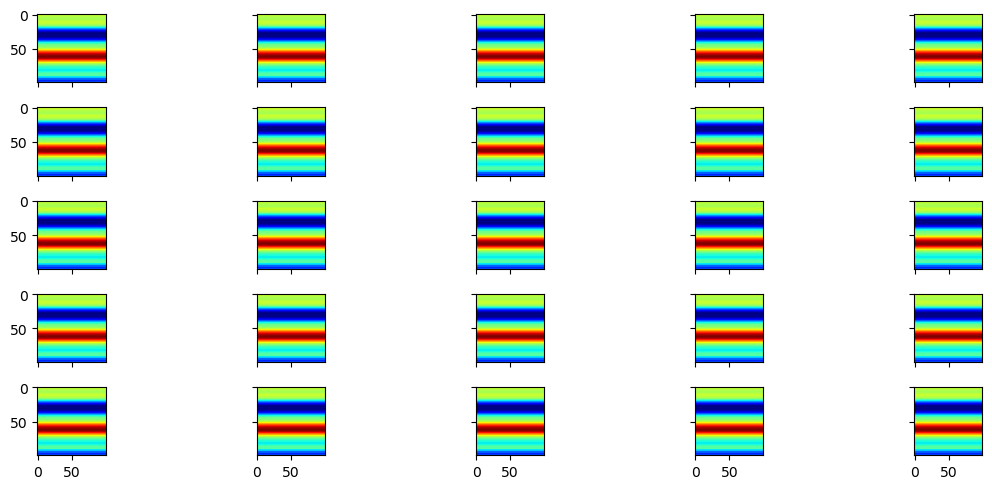

In [183]:
temp = fno(torch.Tensor(xx)).detach().numpy()
print(temp.shape)

fig, axs = plt.subplots(5,5, figsize=(12,5), sharex=True, sharey=True)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        ax.imshow(temp[i,0,:,:,j], cmap='jet')
plt.tight_layout()
plt.show()

In [108]:
sconv = spectral_convolution.SpectralConv3d(in_channels=2, out_channels=4, n_modes=(4,4,1))
y = sconv(m).detach().numpy()
print(y.shape)

(1, 4, 100, 100, 11)


In [114]:
fno = FNO(in_channels=2, out_channels=4, n_modes=(4,4,1), 
          lifting_channels=256, hidden_channels=1024, projection_channels=256,
          n_layers=4, )

f = fno(m).detach().numpy()
print(f.shape)

(1, 4, 100, 100, 11)


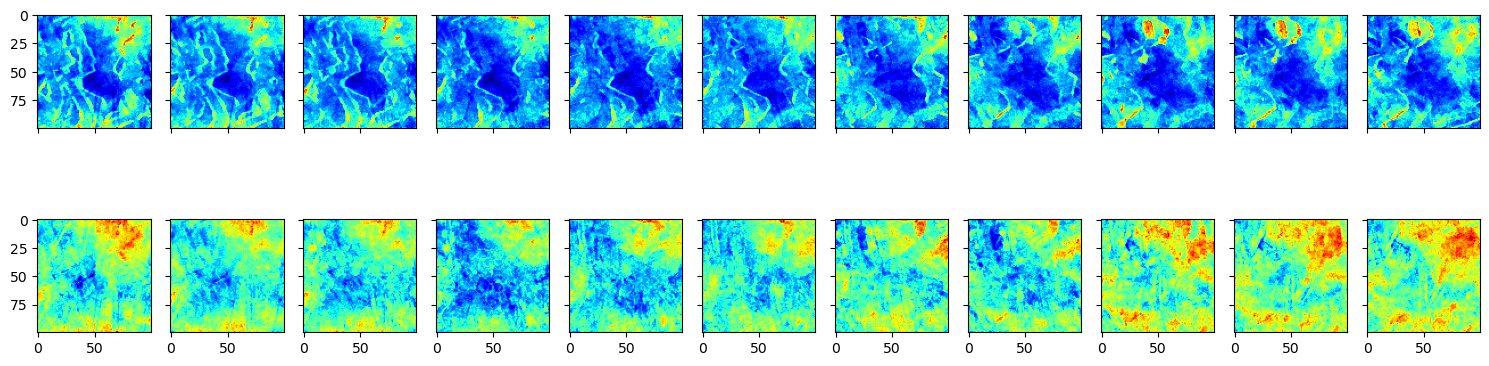

In [110]:
fig, axs = plt.subplots(2, 11, figsize=(15,5), sharex=True, sharey=True)
for i in range(2):
    for j in range(11):
        ax = axs[i,j]
        ax.imshow(m[0,i,:,:,j].detach().numpy(), 'jet')
plt.tight_layout()
plt.show()

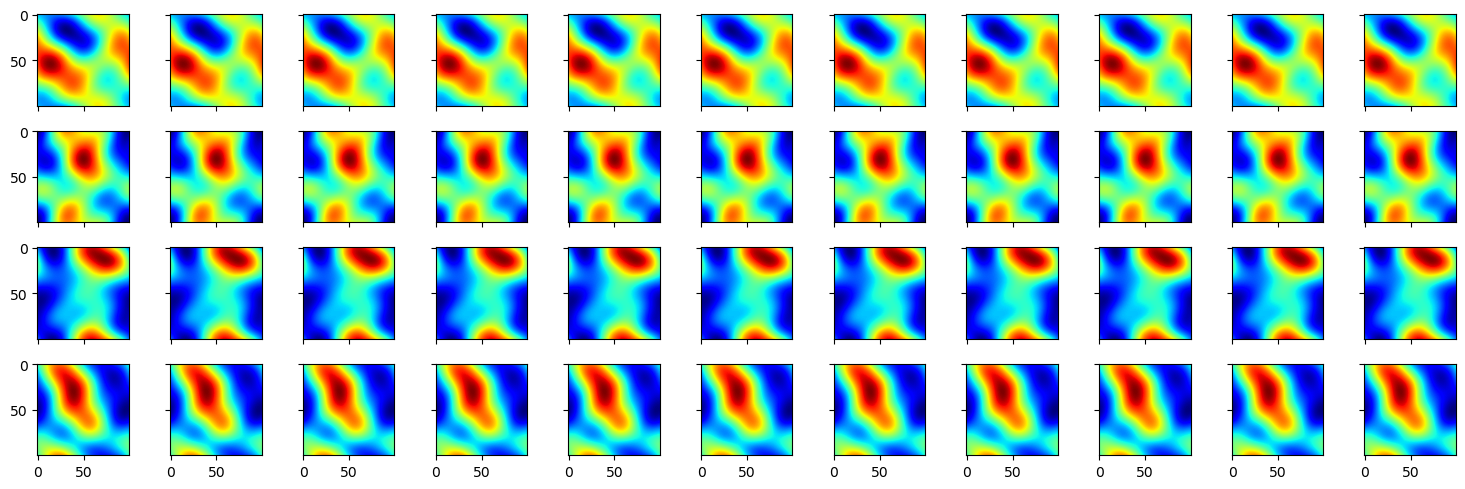

In [109]:
fig, axs = plt.subplots(4, 11, figsize=(15,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(11):
        ax = axs[i,j]
        ax.imshow(y[0,i,:,:,j], 'jet')
plt.tight_layout()
plt.show()

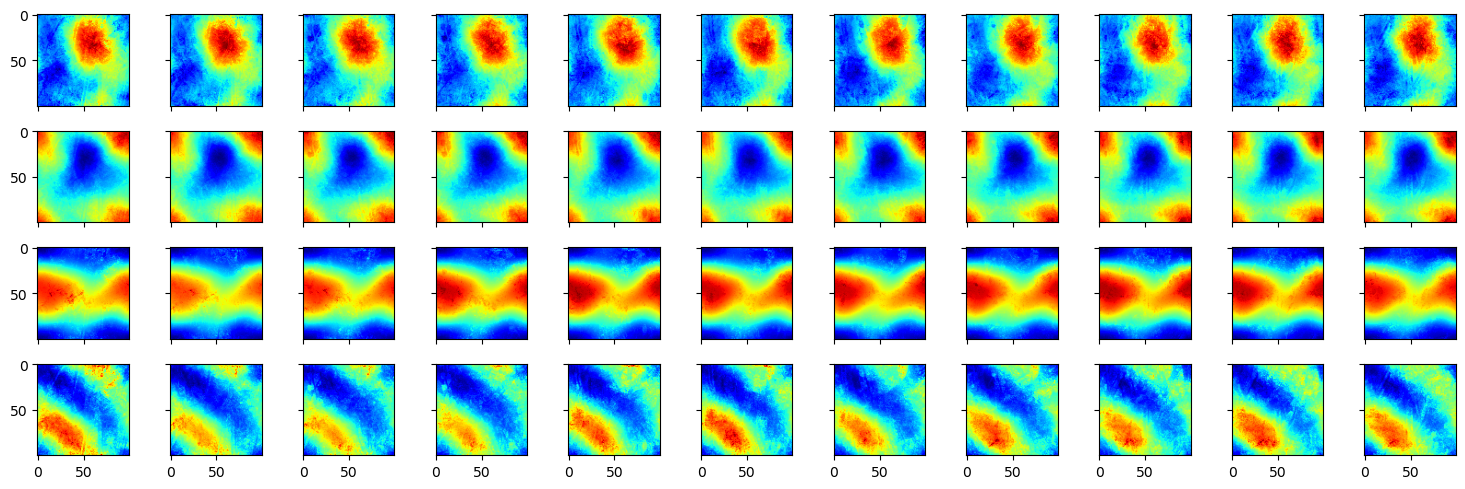

In [115]:
fig, axs = plt.subplots(4, 11, figsize=(15,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(11):
        ax = axs[i,j]
        ax.imshow(f[0,i,:,:,j], 'jet')
plt.tight_layout()
plt.show()

In [48]:
from transformers import VivitConfig, VivitModel, SwinConfig, SwinModel, ViTMAEConfig, ViTMAEModel

In [74]:
vit = ViTMAEModel(ViTMAEConfig(image_size=100, num_channels=11,
                               patch_size=9,
                               num_hidden_layers=12, num_attention_heads=8, 
                               intermediate_size=3072, hidden_size=1024,
                               output_attentions=True, return_dict=True))

y = vit(p)

In [80]:
print(y.keys())

y.

odict_keys(['last_hidden_state', 'mask', 'ids_restore', 'attentions'])


torch.Size([1, 121])

In [ ]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [ ]:
class FTMiONet(nn.Module):
    def __init__(self, hidden_1:int=16, hidden_2:int=32, hidden_3:int=64):
        super(FTMiONet, self).__init__()
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.hidden_3 = hidden_3

        self.conv1 = nn.Conv3d(2, hidden_1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(hidden_2, hidden_3, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm3d(hidden_1)
        self.norm2 = nn.InstanceNorm3d(hidden_2)
        self.norm3 = nn.InstanceNorm3d(hidden_3)
        self.pool = nn.MaxPool3d((1,1,2))
        self.gelu = nn.GELU()

        self.vitm = Swinv2Model(Swinv2Config(image_size=100, num_channels=hidden_3,
                                             embed_dim=96, num_heads=[2,4,8,16],
                                             output_attention=True,
                                             output_hidden_states=True))

        self.vitg = Swinv2Model(Swinv2Config(image_size=100, num_channels=hidden_3,
                                             embed_dim=96, num_heads=[2,4,8,16],
                                             output_attention=True,
                                             output_hidden_states=True))

        self.tel1 = nn.TransformerEncoderLayer(d_model=10, nhead=2, dim_feedforward=1024, activation='gelu', batch_first=True)
        self.tel2 = nn.TransformerEncoderLayer(d_model=160, nhead=8, dim_feedforward=1024, activation='gelu', batch_first=True)
        self.tel3 = nn.TransformerEncoderLayer(d_model=32, nhead=8, dim_feedforward=1024, activation='gelu', batch_first=True)

        self.trf1 = nn.TransformerEncoder(self.tel1, num_layers=4)
        self.trf2 = nn.TransformerEncoder(self.tel2, num_layers=4)
        self.trf3 = nn.TransformerEncoder(self.tel3, num_layers=4)

        self.fno = FNO(n_modes=(1,4), n_layers=2, norm='instance_norm',
                       in_channels=2, 
                       lifting_channels=hidden_1, 
                       hidden_channels=hidden_3, 
                       projection_channels=hidden_1,
                       out_channels=2)
        self.lift = nn.Linear(1920, 29128)

    def forward(self, x):
        xm, xg, xw, xc, xt = x

        zm = self.pool(self.norm1(self.gelu(self.conv1(xm))))
        zm = self.pool(self.norm2(self.gelu(self.conv2(zm))))
        zm = self.pool(self.norm3(self.gelu(self.conv3(zm)))).squeeze()
        mv = self.vitm(zm)
        zm = mv['reshaped_hidden_states'][-1].reshape(zm.shape[0], -1)

        zg = self.pool(self.norm1(self.gelu(self.conv1(xg))))
        zg = self.pool(self.norm2(self.gelu(self.conv2(zg))))
        zg = self.pool(self.norm3(self.gelu(self.conv3(zg)))).squeeze()
        gv = self.vitg(zg)
        zg = gv['reshaped_hidden_states'][-1].reshape(zg.shape[0], -1)

        zw = xw.view(xw.shape[0], -1)
        zw = self.trf1(zw)

        zc = xc.view(xc.shape[0], -1)
        zc = self.trf2(zc)

        zt = xt.view(xt.shape[0], -1)
        zt = self.trf3(zt)

        mg = torch.einsum('bp,bp->bp', zm, zg)
        wc = torch.einsum('bw,bc->bwc', zw, zc)
        zb = torch.einsum('bp,bwc->bwcp', mg, wc)
        zb = zb.reshape(zb.shape[0], 2, 5, 5, 32, 32, 384)
        zb = torch.einsum('blwwttp,blwwttp->blwtp', zb, zb)
        merge = torch.einsum('blwtp,bt->blwtp', zb, zt)
        merge = merge.permute(0,1,3,2,4).reshape(merge.shape[0], 2, 32, -1)
        zy = self.fno(merge)
        yy = self.lift(zy)
        
        return yy

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_folder:str='data_npy_100_100_11'):
        self.data_folder = data_folder
        
        self.x_folder = os.path.join(data_folder, 'inputs_rock_rates_locs_time')
        self.y_folder = os.path.join(data_folder, 'outputs_masked_pressure_saturation')

        self.x_file_list = os.listdir(self.x_folder)
        self.y_file_list = os.listdir(self.y_folder)

    def __len__(self):
        return len(self.x_file_list)
    
    def __getitem__(self, idx):
        x  = np.load(os.path.join(self.x_folder, self.x_file_list[idx]))
        y  = np.load(os.path.join(self.y_folder, self.y_file_list[idx]))

        xg = np.concatenate([np.expand_dims(Tops/(3000), 0), 
                             np.expand_dims(Grid, 0)], 
                             axis=0)

        xm = np.concatenate([np.expand_dims(x['poro']/(0.3),0), 
                             np.expand_dims(x['perm']/(3.3),0)], 
                             axis=0)
        
        xw = x['locs']           / (100)
        xc = x['ctrl'][1:]       * co2_rho*sec2year/mega/1e3/(25)
        xt = x['time'][1:]       / sec2year / (100)
        yp = y['pressure'][2:]   / psi2pascal / (1e4)
        ys = y['saturation'][2:] / 0.8
        yy = np.concatenate([np.expand_dims(yp,0), np.expand_dims(ys,0)], axis=0)

        xm = torch.tensor(xm, dtype=torch.float32, device=device)
        xg = torch.tensor(xg, dtype=torch.float32, device=device)
        xw = torch.tensor(xw, dtype=torch.float32, device=device)
        xc = torch.tensor(xc, dtype=torch.float32, device=device)
        xt = torch.tensor(xt, dtype=torch.float32, device=device)
        yy = torch.tensor(yy, dtype=torch.float32, device=device)

        return (xm, xg, xw, xc, xt), yy

In [ ]:
class MiONet(nn.Module):
    def __init__(self, hidden_channels=16, output_channels=32):
        super(MiONet, self).__init__()
        self.hidden = hidden_channels
        self.output = output_channels

        self.conv1 = nn.Conv3d(2, self.hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(self.hidden, self.output, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm3d(self.hidden)
        self.norm2 = nn.BatchNorm3d(self.output)
        self.pool  = nn.MaxPool3d(2)
        self.gelu  = nn.GELU()

        self.linW1 = nn.Linear(5, self.hidden)
        self.linW2 = nn.Linear(self.hidden, self.output)
        self.bnW1  = nn.BatchNorm1d(self.hidden//8)
        self.bnW2  = nn.BatchNorm1d(self.output//16)

        self.lstmC1 = nn.LSTM(5, self.hidden, num_layers=1, batch_first=True)
        self.lstmC2 = nn.LSTM(self.hidden, self.output, num_layers=1, batch_first=True)

        self.lmstT1 = nn.LSTM(1, self.hidden, num_layers=1, batch_first=True)
        self.lmstT2 = nn.LSTM(self.hidden, self.output, num_layers=1, batch_first=True)

        self.linY1 = nn.Linear(1250, 10000)
        self.linY2 = nn.Linear(10000, 29128)

    def forward(self, x):
        xm, xg, xw, xc, xt = x

        zm = self.gelu(self.pool(self.norm1(self.conv1(xm))))
        zm = self.gelu(self.pool(self.norm2(self.conv2(zm))))
        zm = zm.view(zm.shape[0], self.output, -1)

        zg = self.gelu(self.pool(self.norm1(self.conv1(xg))))
        zg = self.gelu(self.pool(self.norm2(self.conv2(zg))))
        zg = zg.view(zg.shape[0], self.output, -1)

        zw = self.gelu(self.bnW1(self.linW1(xw)))
        zw = self.gelu(self.bnW2(self.linW2(zw)))

        zc, _ = self.lstmC1(xc)
        zc, _ = self.lstmC2(zc)

        zt, _ = self.lmstT1(xt)
        zt, _ = self.lmstT2(zt)

        mg = torch.einsum('bcp,bcp->bcp', zm, zg)
        wc = torch.einsum('blc,btc->btlc', zw, zc)
        branch = torch.einsum('bcp,btlc->btpl', mg, wc)
        merge  = torch.einsum('btpl,btc->btlp', branch, zt)

        yy = self.gelu(self.linY1(merge))
        yy = self.linY2(yy)

        return yy

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.85, beta=0.20):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.ssim = SSIMLoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, true, pred):
        mse_loss = self.mse(true, pred)
        mae_loss = self.mae(true, pred)
        ssim_loss = 1 - self.ssim(true, pred)
        return self.alpha(self.beta*mse_loss + (1-self.beta)*mae_loss) + (1-self.alpah)*ssim_loss

In [ ]:
dataset = CustomDataset()
trainset, testset  = random_split(dataset, [1172, 100])
trainset, validset = random_split(trainset, [1000, 172])

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validloader = DataLoader(validset, batch_size=32, shuffle=False)
testloader  = DataLoader(testset,  batch_size=10, shuffle=False)

In [ ]:
model = FTMiONet().to(device)
model.load_state_dict(torch.load('trained_models/FTMiONet.pth'))
print('# Parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

criterion = nn.MSELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [ ]:
for i, (x,y) in enumerate(testloader):
    yh = model(x)
    break

In [ ]:
print(yh.shape)

In [ ]:
Grid_ext = np.repeat(np.expand_dims(Grid, 0), 32, axis=0)
print('Extended Grid: {}'.format(Grid_ext.shape))

timesteps = 100*x[-1][0].squeeze().detach().cpu().numpy()
print(timesteps.shape)

In [ ]:
spred = np.zeros((32,100,100,11)).reshape(32, -1, order='F')
maskt = Grid_ext.reshape(32, -1, order='F')

spred[:,indexMap] = yh[0,0].detach().cpu().numpy()
spred = np.ma.masked_where(maskt==0, spred)
spred = spred.reshape(32,100,100,11, order='F')

fig, axs = plt.subplots(4, 8, figsize=(16,8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(spred[i,:,:,7], cmap='jet')
    ax.set(title='t={:.2f}'.format(timesteps[i]))
plt.tight_layout()
plt.show()

In [ ]:
strue = np.zeros((32,100,100,11)).reshape(32, -1, order='F')
maskt = Grid_ext.reshape(32, -1, order='F')

strue[:,indexMap] = y[0,0].detach().cpu().numpy()
strue = np.ma.masked_where(maskt==0, strue)
strue = strue.reshape(32,100,100,11, order='F')

fig, axs = plt.subplots(4, 8, figsize=(16,8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(strue[i,:,:,5], cmap='jet', vmin=0.25, vmax=2.50)
    ax.set(title='t={:.2f}'.format(timesteps[i]))
plt.tight_layout()
plt.show()

In [ ]:
history = pd.read_csv('MiONet_losses.csv')

def plot_loss(history, figsize=(8,4)):
    plt.figure(figsize=figsize)
    plt.plot(history.index, history['train'], ls='-', label='Train')
    plt.plot(history.index, history['valid'], ls='-', label='Valid')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True, which='both')
    plt.tight_layout(); plt.savefig('loss.png'); plt.show()
    return None
plot_loss(history)

***
# END